# Data analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
from scipy import stats

##### Helpful functions

In [39]:
def print_results(pval, conf):
    print("P-value = {}".format(pval))
    if pval < conf:
        print("Reject null hypothesis.")
    else:
        print("Fail to reject null hypothesis.")

In [4]:
csvfile = "meetings_complete_clean.csv"

In [5]:
converters = dict(Time_dt=pd.to_datetime, Time_del=pd.to_timedelta)

In [6]:
df = pd.read_csv(csvfile, converters=converters)

In [7]:
df.head()

,Name,Day,Time,Video,Desc,Categories,Email,Phone,Time_dt,Time_del,...,Label_Game,Label_Blind / Visually Impaired,Label_Deaf / Hard of Hearing,Label_Email,Label_Professionals,Label_Meditation,Label_Seniors,Label_Newcomer,Label_24/7,Zoom
0,1 Hole in the Sky AA Meetings: AA Secular Dail...,Tuesday,5:00 pm,https://zoom.us/j/414948190,Tuesday: AA Secular Daily Reflections 3:00pm P...,"Audio,Open,Video",NaN,NaN,2021-11-17 17:00:00,0 days 17:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,AA Friends,Tuesday,5:00 pm,https://aafriends.webs.com/,AA Friends currently holds three online meetin...,"Forum,Open",aafriends@usa.com,NaN,2021-11-17 17:00:00,0 days 17:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,AA New Beginnings,Tuesday,5:00 pm,https://us02web.zoom.us/j/5662326551,"A daily meeting that focuses on experience, st...","Audio,Big Book,Discussion,Open,Video",AANewBeginnings230@gmail.com,NaN,2021-11-17 17:00:00,0 days 17:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,Agnes Water,Tuesday,5:00 pm,https://us02web.zoom.us/j/8983968244,PW billw,"Big Book,Discussion,Speaker,Video",agneswaterxa@gmail.com,NaN,2021-11-17 17:00:00,0 days 17:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,Beginners AA meeting,Tuesday,5:00 pm,https://us02web.zoom.us/j/88198562544?pwd=wfzm...,"Zoom Passcode, if any: serenity","Big Book,Discussion,Open,Speaker,Video",liaazoom2020@gmail.com,NaN,2021-11-17 17:00:00,0 days 17:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [8]:
df.shape

(4155, 37)

In [10]:
# Add column with time in total seconds for easier calculations
df['Time_sec'] = df['Time_del'].dt.total_seconds()

For evaluating day and time patterns, best to remove ongoing meetings:

In [11]:
# df "minus ongoing"
df_mo = df.drop(df[df['Day'].str.contains('Ongoing')].index)

In [12]:
df_mo.shape

(4078, 38)

### One sample t-test

In [40]:
print("Average time of all non-ongoing meetings:")
df_mo['Time_del'].mean()

Average time of all non-ongoing meetings:


Timedelta('0 days 14:10:38.357037763')

In [45]:
avg_time = df_mo['Time_sec'].mean()

**Null hypothesis:** The average time of men's meetings = 14:10:38

**Alternative hypothesis:** The average time of men's meetings /= 14:10:38

**Confidence level:** alpha = 0.05

In [46]:
male_mask = df_mo['Label_Men'] == 1

In [47]:
df_mo[male_mask]['Time_del'].mean()

Timedelta('0 days 16:00:58.301886792')

In [48]:
df_mo[male_mask]['Time_sec'].mean()

57658.301886792455

In [49]:
sample1 = df_mo[male_mask]['Time_sec']
tset1, pval1 = stats.ttest_1samp(sample1, avg_time)

print_results(pval1, 0.05)

P-value = 0.0002425719732924799
Reject null hypothesis.


In other words, we are 95% confident that the average time of men's meetings is significantly different from the average time of all meetings. Keep in mind that because this is a dataset that is both international and timezone-naive, this effect could be due to local rather that time preference. (That is, perhaps there are more men's meetings in the eastern hemisphere, etc.)

### Two sample t-test

It is a pop psych truism that women are more verbose than men. Here is an independent t-test to evaluate whether the description field for women's meetings is longer than that of men's meetings.

First, we add a column indicating the total character length of the description field:

In [67]:
df['Desc_length'] = df['Desc'].str.len()

Then, separate out samples consisting of women's meetings and men's meetings:

In [70]:
women_mask = df['Label_Women'] == 1
men_mask = df['Label_Men'] == 1

In [74]:
women_desc_len_sample = df[women_mask]['Desc_length']
men_desc_len_sample = df[men_mask]['Desc_length']

In [81]:
women_desc_len_sample.mean(), men_desc_len_sample.mean()

(79.1025641025641, 62.31192660550459)

The women's mean is greater than the men's mean, which is a nice preliminary support for doing a **one-tailed test:**

**Null hypothesis:** The average length of description of women's meetings <= the average length of description of men's meetings 

**Alternative hypothesis:** The average length of description of women's meetings > the average length of description of men's meetings 

**Confidence level:** alpha = 0.05

##### Check key assumption: homogeneity of variance

In [75]:
stats.levene(women_desc_len_sample, men_desc_len_sample, center='mean')

LeveneResult(statistic=2.378961556272901, pvalue=0.1237341501771085)

Since the p-value is much greater than 0.05, the Levene's test is not significant, indicating the groups do not have a different amount of variation. Thus we can proceed to the independent t test:

In [82]:
tstat2, pval2 = stats.ttest_ind(women_desc_len_sample, men_desc_len_sample)
print(tstat2)

1.7424899816344992


According to scipy.stats.ttest_ind documentation, this only outputs two-tailed results, and gives a signed test statistic. For given t and p values from a two-tailed test, we reject the null hypothesis of a greater-than test when `p/2 < alpha and t > 0`, and of a less-than test when `p/2 < alpha and t < 0`. We are conducting a greater-than test and the test statistic is greater than 0, so:

In [83]:
print_results((pval2/2), 0.05)

P-value = 0.04107821481145321
Reject null hypothesis.


Thus, we can say we are 95% confident the average length of the description of women's meetings is significantly greater than that of men's meetings.

### Chi square test of independence of variables

A "closed" AA meeting is one which is more restrictive of who can attend. Another pop psych truism is that because women are much more likely to be victims of stalking and/or assault, female-focused groups are more often restrictive of who can attend in order to create a "safe space" for women. We can use a chi square test to examine whether the "women" category and "closed" category are correlated in this dataset.

First, create a contingency table using pandas' cross-tabulation method:

In [85]:
women_closed_table = pd.crosstab(df['Label_Women'], df['Label_Closed'])
women_closed_table

Label_Closed,0.0,1.0
Label_Women,,
0.0,2943,900
1.0,99,213


In [86]:
# Sanity check
900/(2943+900), 213/(99+213)

(0.234192037470726, 0.6826923076923077)

The chi square test for a contingency table:

In [102]:
chi_stat, pval_chi, dof, expected = stats.chi2_contingency(women_closed_table)
print_results(pval_chi, 0.01)

P-value = 7.766512354804441e-66
Reject null hypothesis.


We can reject the null hypothesis, which is that there is no relationship between these two variables in the population. This time we used a lower alpha value of 0.01, so we can say we are 99% confident there is a relationship.

This test returns an array of the expected values if the null hypothesis was true; here is a side-by-side visual comparison of that table of expected values vs the table of actual values:

In [100]:
expected_table = pd.DataFrame(expected, index=women_closed_table.index, columns=women_closed_table.columns)
expected_table

Label_Closed,0.0,1.0
Label_Women,,
0.0,2813.575451,1029.424549
1.0,228.424549,83.575451


<IPython.core.display.Javascript object>


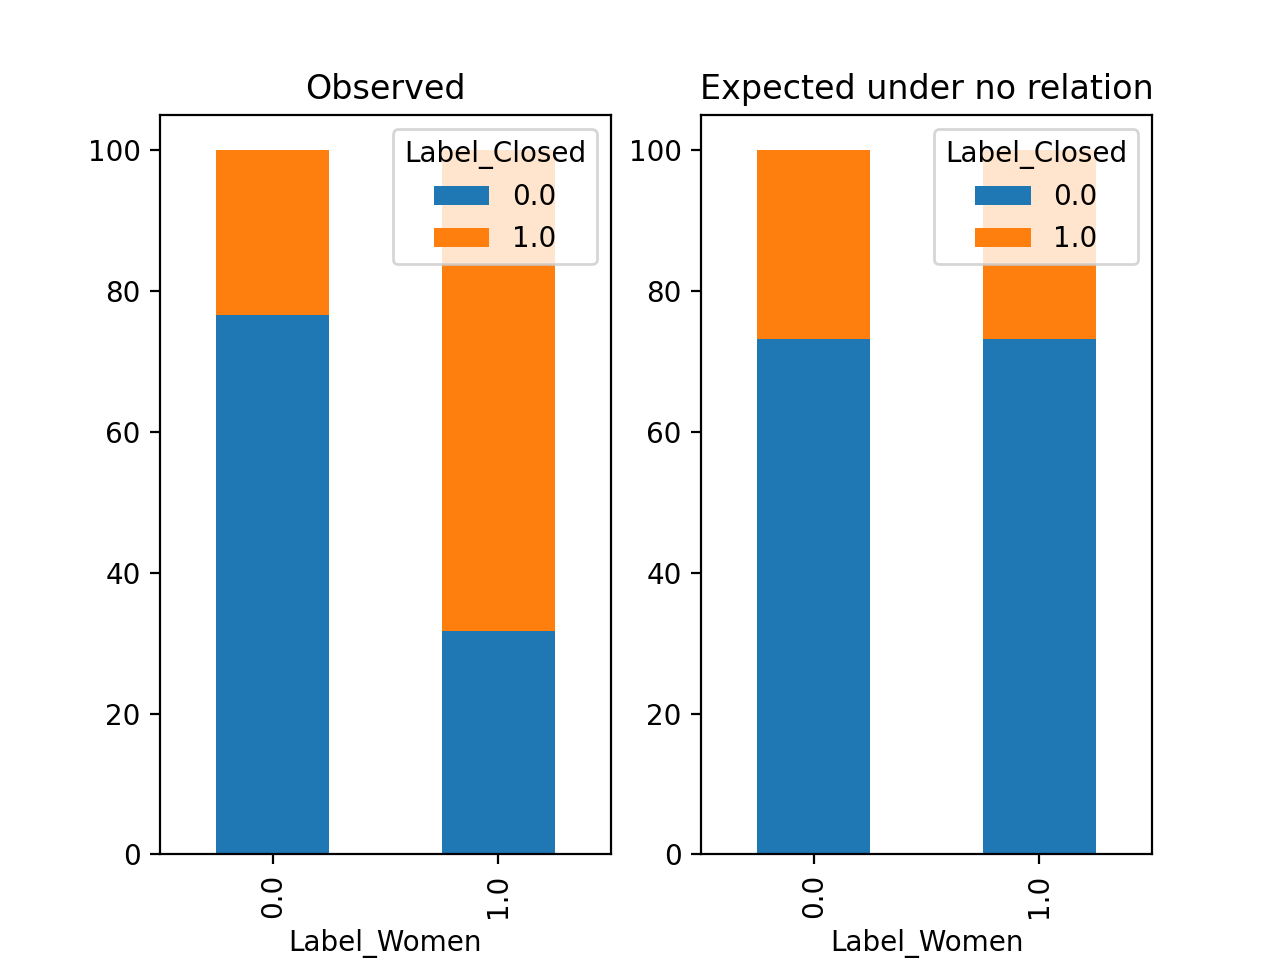

In [101]:
fig, axes = plt.subplots(1, 2)
(100*(women_closed_table.T/women_closed_table.apply(sum, axis=1)).T)\
.plot(kind='bar', stacked=True, title='Observed', ax=axes[0]);

(100*(expected_table.T/expected_table.apply(sum, axis=1)).T)\
.plot(kind='bar', stacked=True, title='Expected under no relation', ax=axes[1]);